In [1]:
import rasterio  
from pyproj import CRS  
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage
from rasterio.warp import reproject, Resampling, calculate_default_transform  

from pyproj import CRS  
import numpy as np
from config import Config


In [2]:
def normalize_zoom_matrix(data, normalize = True, zoom_value = 1.0):
    original_shape = data.shape  

    if normalize:
        # Desired square size  
        desired_size = min(original_shape)  
        
        if normalize:
            # Calculate resampling ratio  
            resample_ratio = (desired_size / np.array(original_shape)  ) * zoom_value
        else:
            resample_ratio = zoom_value
        if not normalize and zoom_value == 1:
            return data      
        # Use scipy's ndimage.zoom function to resample  
        data = scipy.ndimage.zoom(data, resample_ratio)

    return data

In [3]:
def visualize_jp2(file_name: str):
    with rasterio.open(file_name) as src:  
        data = src.read()
    data = data[0]
    data = normalize_zoom_matrix(data, zoom_value=2)
    plt.close('all')
    fig = plt.figure(figsize=(50, 50))  
        
        # Create a GeoAxes in the tile's projection  
    ax = plt.axes()
        # Add the image to the map  
    img = ax.imshow(data, origin='upper', cmap='gray')
    plt.axis('off')  

    plt.savefig(f"output_visualized.png", bbox_inches='tight', pad_inches = 0, transparent=True) 


Reprojection is completed, now visualizing


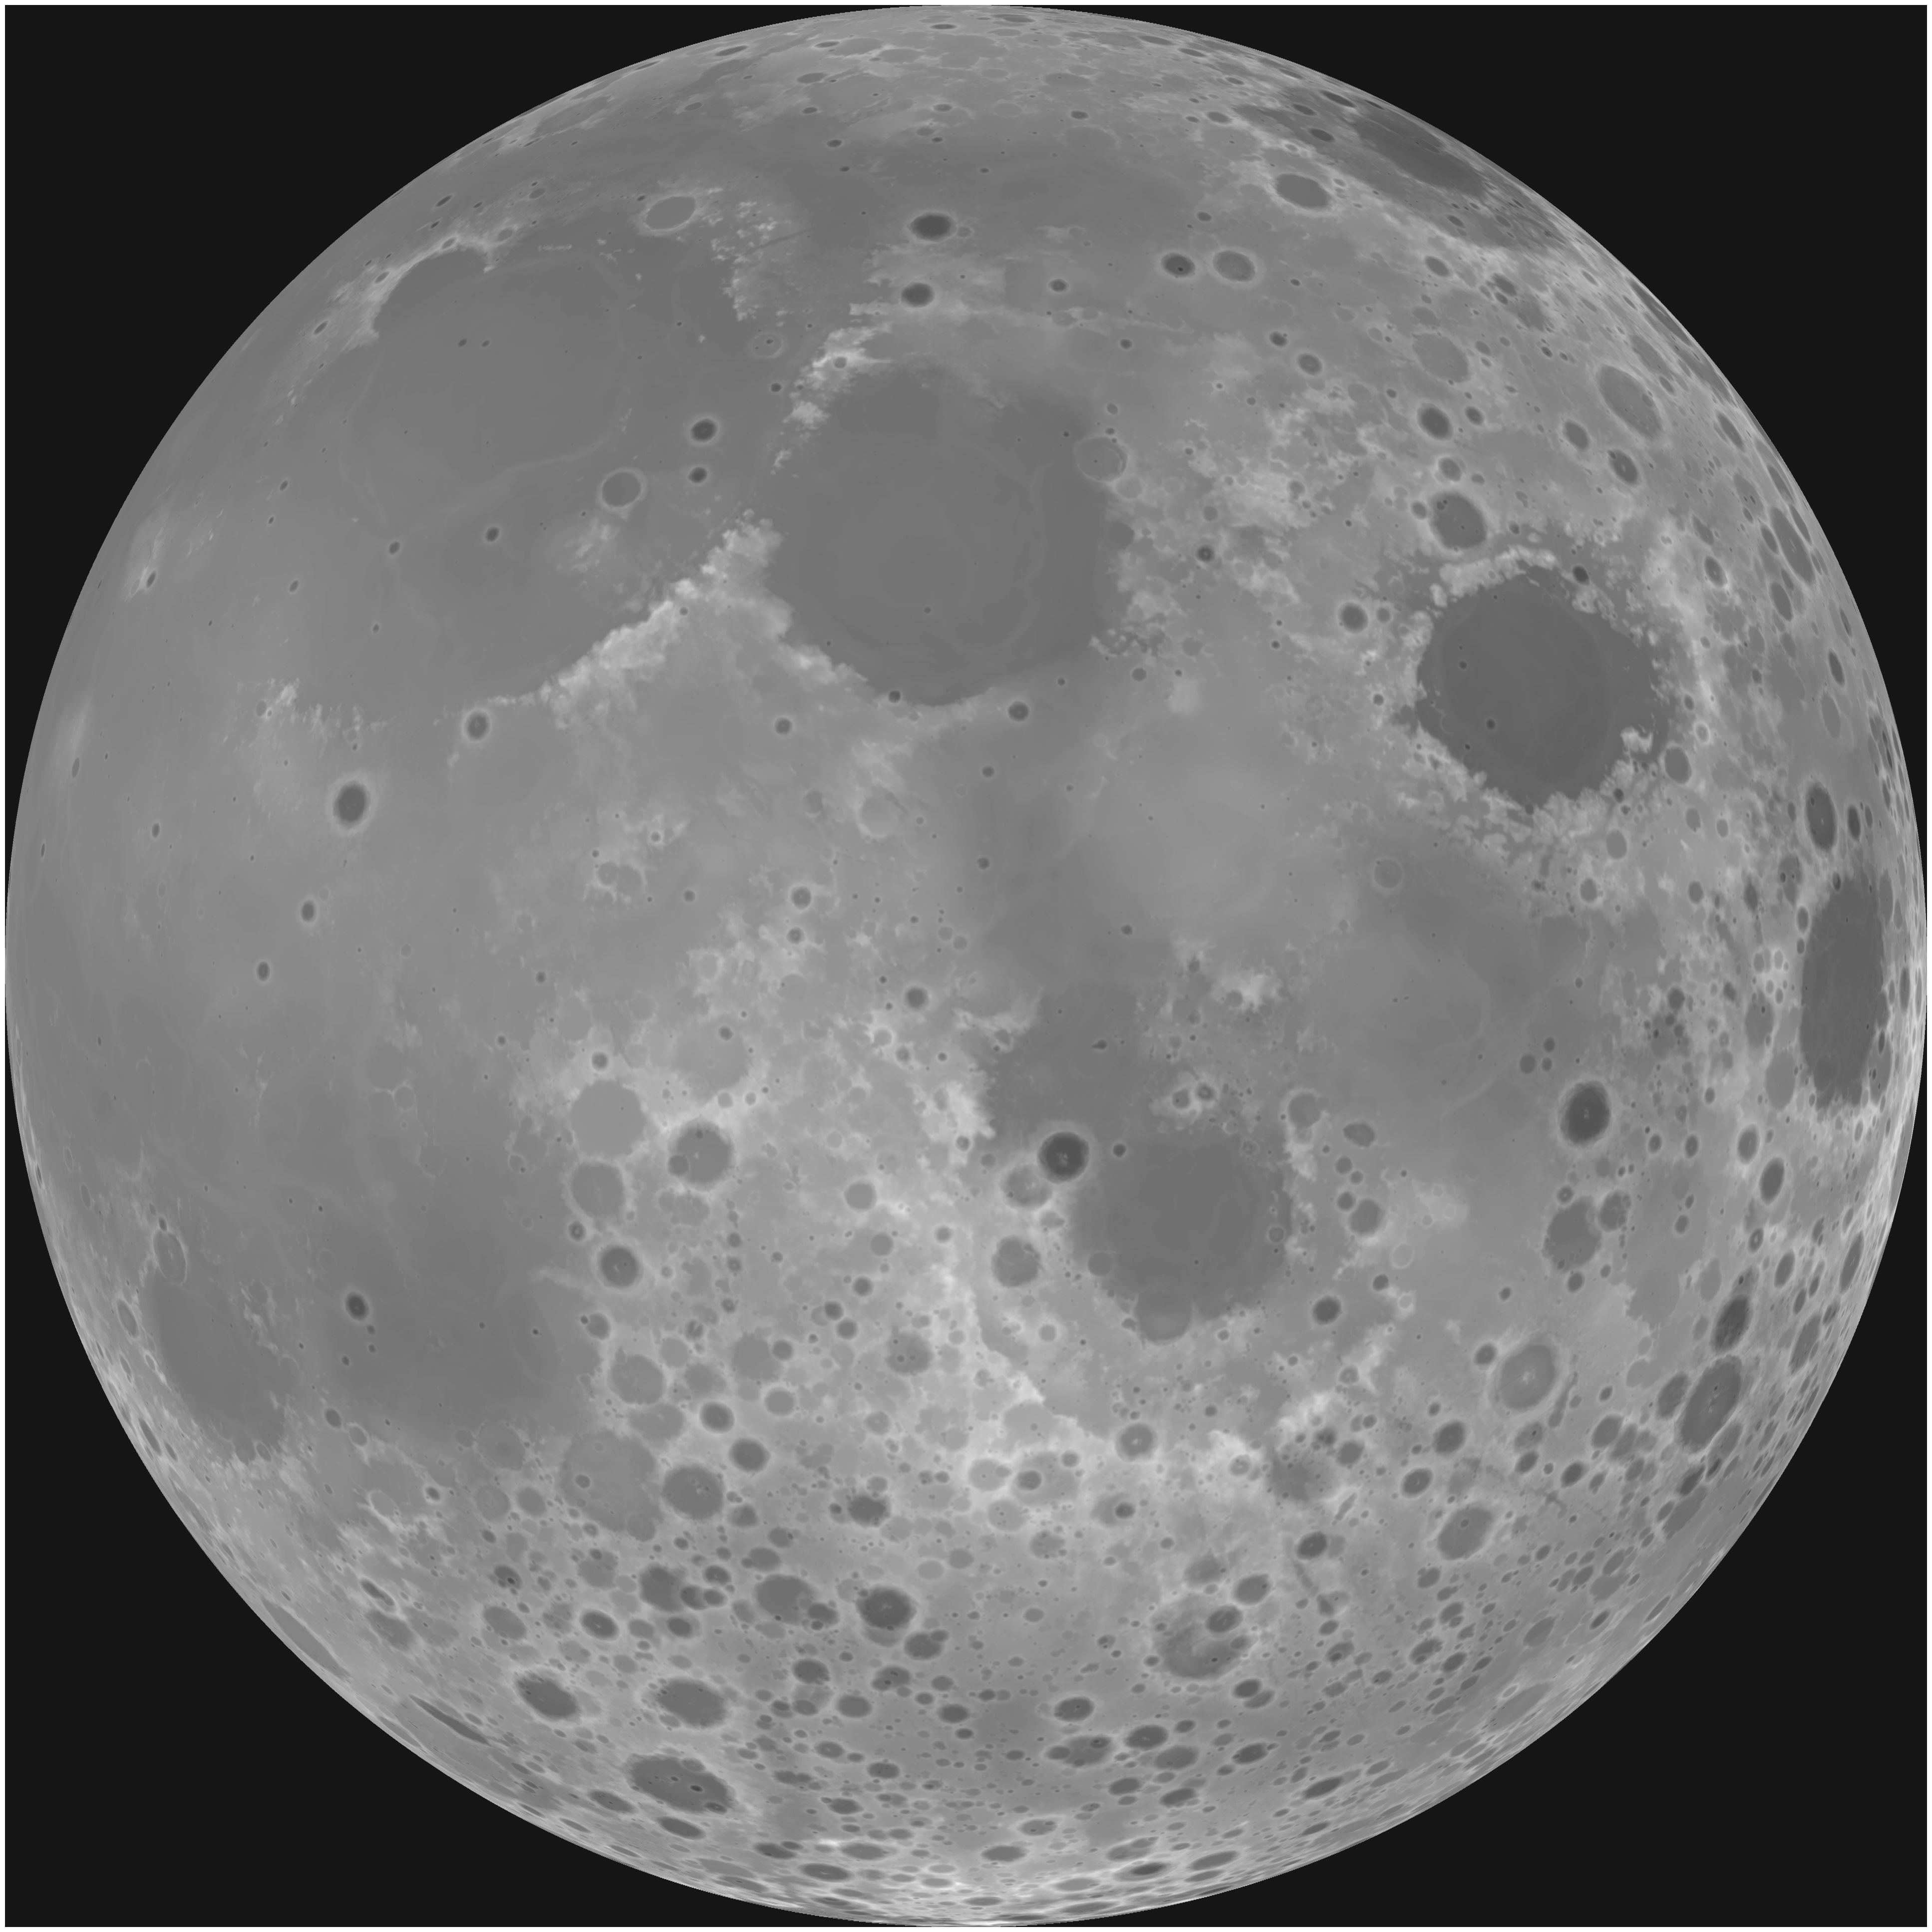

In [4]:

def reproject_jp2(file_name: str, output_name:str = 'output_reprojected.jp2'):
    cfg = Config()

    if cfg.apply_default_transformation:
        # Define the new coordinate system you want to reproject to  
        dst_crs = CRS.from_proj4('+proj=ortho +R=1737400 +lon_0=20.4 +lat_0=0.0 +h=3578583100 +x_0=0 +y_0=0 +units=m +sweep=y +no_defs +type=crs')
    else:
        dst_crs = cfg.custom_transformation_proj4  
    #dst_crs = CRS.from_proj4('+proj=ortho +ellps=sphere +lon_0=30 +lat_0=0.0 +x_0=0 +y_0=0 +no_defs +type=crs')  
    
    # Open the JP2 file  
    with rasterio.open(file_name) as src:  
        src_array = src.read(1)  
        src_meta = src.meta  
    
    # Define the destination array (filled with zeros)  
    dst_array = np.zeros_like(src_array)


    # Reproject the source array to the destination array  
    reproject(  
        source=src_array + abs(np.min(src_array) + 10),  
        destination=dst_array,  
        src_transform=src.transform,
        src_crs=src_meta['crs'],  
        dst_crs=dst_crs,  
        resampling=Resampling.cubic)  
    
    
    # Update the metadata for the new file  
    src_meta.update({  
        'crs': dst_crs    
        })  
    # Write the reprojected data to a new file  
    with rasterio.open(output_name, 'w', **src_meta) as dst:  
        dst.write(dst_array, 1)


reproject_jp2('img_repo\LDEM_16.JP2', 'reprojected_output.jp2')
print("Reprojection is completed, now visualizing")
visualize_jp2('reprojected_output.jp2')



In [3]:

def reproject_jp2(file_name: str, output_name:str = 'output_reprojected.jp2'):
    cfg = Config()

    if cfg.apply_default_transformation:
        # Define the new coordinate system you want to reproject to  
        dst_crs = CRS.from_proj4('+proj=ortho +R=1737400 +lon_0=0.4 +lat_0=15.0 +h=35785831 +x_0=0 +y_0=0 +units=m +sweep=y +no_defs +type=crs')
    else:
        dst_crs = cfg.custom_transformation_proj4  
    #dst_crs = CRS.from_proj4('+proj=ortho +ellps=sphere +lon_0=30 +lat_0=0.0 +x_0=0 +y_0=0 +no_defs +type=crs')  
    
    # Open the JP2 file  
    with rasterio.open(file_name) as src:  
        src_array = src.read(1)  
        src_meta = src.meta  
    
    # Define the destination array (filled with zeros)  
    dst_array = np.zeros_like(src_array)  
    
    # Reproject the source array to the destination array  
    reproject(  
        source=src_array + abs(np.min(src_array) + 10),  
        destination=dst_array,  
        src_transform=src.transform,  
        src_crs=src_meta['crs'],  
        dst_crs=dst_crs,  
        resampling=Resampling.bilinear)
    
    
    # Update the metadata for the new file  
    src_meta.update({  
        'crs': dst_crs    
        })  
    # Write the reprojected data to a new file  
    with rasterio.open(output_name, 'w', **src_meta) as dst:  
        dst.write(dst_array, 1) 
reproject_jp2('img_repo\LDEM_64.JP2', 'output_3.jp2')


In [50]:
def divide_matrix(matrix, num_of_divisions : int = 5, width_of_division: int = 100):
    """Given a 2d square matrix, divide it into num_of_divisions x num_of_divisions of squares equal in size submatrices by adding zeros between each division with the width of width_of_division
    Input:
    matrix : 2d numpy array
    num_of_divisions : int : number of divisions in each axis
    width_of_division : int : width of the division
    Output:
    divided_matrix : 2d numpy array : divided matrix
    """
    # Get the shape of the matrix
    shape = matrix.shape
    # Get the number of rows and columns
    rows, _ = shape
    # Get the division locations
    div_index = rows // num_of_divisions
    # Add zeros between each division
    for i in range(1, num_of_divisions):
        matrix = np.insert(matrix, div_index*i + (width_of_division * (i-1)), np.zeros((width_of_division, matrix.shape[1])), axis=0)
    for i in range(1, num_of_divisions):
        matrix = np.insert(matrix, div_index*i + (width_of_division * (i-1)), np.zeros((width_of_division, matrix.shape[0])), axis=1)

    return matrix

In [111]:
import rasterio  
from rasterio.warp import calculate_default_transform, reproject, Resampling  
from pyproj import CRS  
  
# Define the existing coordinate system  
src_crs = CRS.from_proj4('+proj=longlat +a=1737400 +b=1737400 +no_defs')  # WGS84  
  
# Define the new coordinate system you want to reproject to  
dst_crs = CRS.from_proj4('+proj=ortho +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=1737400 +b=1737400 +units=m +no_defs')  # Web Mercator  
  
# Open the JP2 file  
with rasterio.open('img_repo\LDEM_16.JP2') as src:  
  
    transform, width, height = calculate_default_transform(  
        src_crs, dst_crs, src.width, src.height, *src.bounds)  
      
    kwargs = src.meta.copy()  
    kwargs.update({  
        'crs': dst_crs,  
        'transform': transform,  
        'width': width,  
        'height': height  
    })  
  
    # Reproject and write the reprojected data to a new file  
    with rasterio.open('output.jp2', 'w', **kwargs) as dst:  
        for i in range(1, src.count + 1):  
            reproject(  
                source=rasterio.band(src, i),  
                destination=rasterio.band(dst, i),  
                src_transform=src.transform,  
                src_crs=src_crs,  
                dst_transform=transform,  
                dst_crs=dst_crs,  
                resampling=Resampling.nearest)  


In [189]:
import rasterio  
from rasterio.warp import reproject, Resampling  
from pyproj import CRS, Transformer  
import numpy as np  
  
# Define the existing coordinate system  
src_crs = CRS.from_proj4('+proj=longlat +a=1737400 +b=1737400 +no_defs')  
  
# Define the new coordinate system you want to reproject to  
dst_crs = CRS.from_proj4('+proj=merc +a=1737400 +b=1737400 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +no_defs')  
  
# Create a transformer object for reprojection  
transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)  
  
# Open the JP2 file  
with rasterio.open('img_repo\LDEM_16.JP2') as src:  
  
    # Get the source array and its metadata  
    src_array = src.read(1)  
    src_meta = src.meta  
  
    # Define the destination array (filled with zeros)  
    dst_array = np.zeros_like(src_array)  
  
    # Reproject the source array to the destination array  
    reproject(  
        source=src_array + abs(np.min(src_array) + 100),  
        destination=dst_array,  
        src_transform=src.transform,  
        src_crs=src.crs,  
        dst_transform=transformer.transform(),  # Note: Here we use the same transform for source and destination  
        dst_crs=dst_crs,  
        resampling=Resampling.nearest)  
  
    # Update the metadata for the new file  
    src_meta.update({  
        'crs': dst_crs,  
        'transform': src.transform  # Note: Here we use the same transform for source and destination  
    })  
  
    # Write the reprojected data to a new file  
    with rasterio.open('output.jp2', 'w', **src_meta) as dst:  
        dst.write(dst_array, 1)  


TypeError: Transformer.transform() missing 2 required positional arguments: 'xx' and 'yy'

In [141]:
from osgeo import gdal  
  
input_raster = gdal.Open('img_repo\LDEM_64.JP2')  
output_raster = 'output.jp2'  
  
# Define target spatial reference with PROJ4 string  
proj4_string = '+proj=ortho +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=1737400 +b=1737400 +units=m +no_defs'  
  
warp = gdal.Warp(output_raster,   
                 input_raster,   
                 dstSRS=proj4_string)  
  
# Clear the variable  
warp = None

In [188]:
matrix = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])  
matrix + 1

array([[ 2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16]])